## Introduction
This notebook explores the MNIST dataset using Convolutional Neural Networks for classification tasks.
We will be building a lightweight CNN model to classify MNIST Handwritten digit dataset.

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import time
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing
We are normalizing data with mean=0.5 and variance=0.5.


In [ ]:
# Define data transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 32978327.28it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101199410.05it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27791741.10it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 672426.98it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Model Training
A CNN model with dropout and Linear layers will be built.
The goal is to keep model lightweight.

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adjusted input size for linear layer
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 5

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
%%time
epochs_iterator = tqdm(range(num_epochs), desc='Epochs')
start_time = time.time()

for epoch in epochs_iterator:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    data_iterator = tqdm(enumerate(train_loader), desc='Batches', total=len(train_loader), leave=False)

    for batch_idx, (data, targets) in data_iterator:
        optimizer.zero_grad()
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        data_iterator.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.5f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, Accuracy: {epoch_acc:.2f}%')

    # Update LR scheduler
    scheduler.step()

    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            test_loss += criterion(outputs, targets).item()

    test_acc = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_acc)
    print(f'Test Accuracy: {test_acc:.2f}%')

end_time = time.time()

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.18314, Accuracy: 94.41%
Test Accuracy: 98.60%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/5], Loss: 0.06482, Accuracy: 98.01%
Test Accuracy: 98.73%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/5], Loss: 0.05018, Accuracy: 98.44%
Test Accuracy: 99.09%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/5], Loss: 0.02978, Accuracy: 99.07%
Test Accuracy: 99.31%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/5], Loss: 0.02562, Accuracy: 99.18%
Test Accuracy: 99.30%
CPU times: user 1min 43s, sys: 2.39 s, total: 1min 45s
Wall time: 1min 55s


In [ ]:
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 115.90 seconds


## Model Evaluation

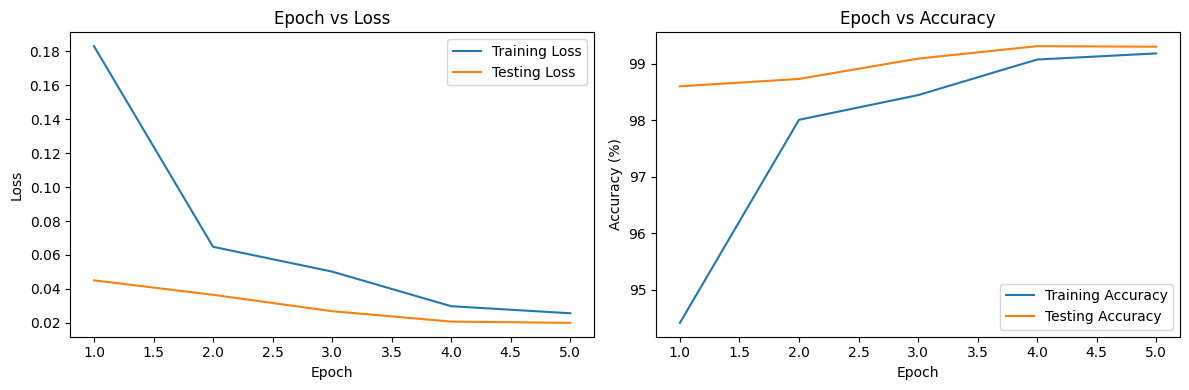

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predicted_labels = []
true_labels = []

model.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())


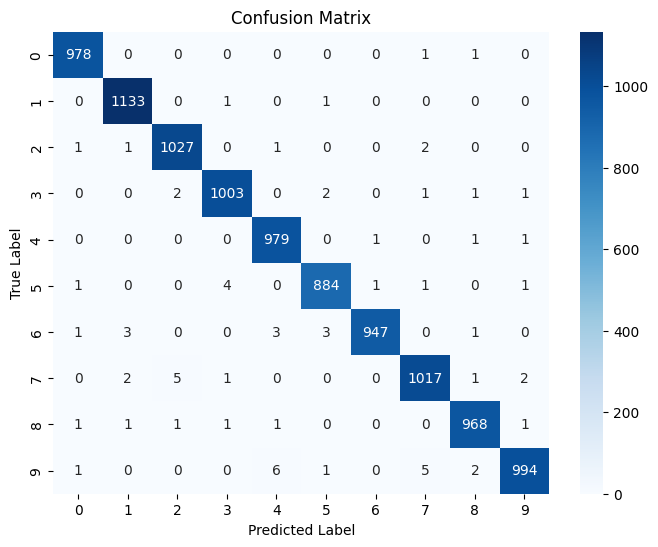

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
classification_rep = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
es = accuracy_score(true_labels, predicted_labels)

# Calculate the margin of error
margin_of_error = 1.96 * np.sqrt(es * (1 - es) / len(true_labels))

# Calculate the confidence interval
confidence_interval = (es - margin_of_error, es + margin_of_error)

print(f"95% Confidence Interval: {confidence_interval}")

95% Confidence Interval: (0.9913658959151878, 0.9946341040848122)


In [ ]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms


# Load the image
image_path = '/content/temp.png'
image = Image.open(image_path)

# Convert the image to grayscale
gray_image = image.convert('L')

# Convert the grayscale image to a NumPy array
image_array = np.array(gray_image)

# Normalize and standardize the image array (adjust these transforms based on your model)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply the transformations
input_tensor = transform(image_array)

# Add batch dimension
input_tensor = input_tensor.unsqueeze(0)


# Make sure the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    output = model(input_tensor.to(device))

# Process the output as needed


In [ ]:
output

tensor([[ 0.1852, -2.6701,  0.9134,  0.7296, -2.5256,  0.2042, -1.7007, -1.2085,
          0.0323,  0.5016]], device='cuda:0')

In [ ]:
_, predicted = torch.max(output.data, 1)
predicted

tensor([2], device='cuda:0')